In [53]:
import tensorflow as tf
# Enable eager execution
tf.config.experimental_run_functions_eagerly(True)

import matplotlib.pyplot as plt
import numpy as np
import os
import random

from PIL import Image
from pathlib import Path
from transformers import AutoFeatureExtractor, TFAutoModelForImageClassification, ViTImageProcessor
from datasets import load_dataset



In [80]:
# Load your data
data_dir = 'C:\\Users\\franc\\Documents\\GitHub\\Car_Detection_Chat\\testando'

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)


Found 5229 files belonging to 21 classes.
Using 4184 files for training.
Found 5229 files belonging to 21 classes.
Using 1045 files for validation.


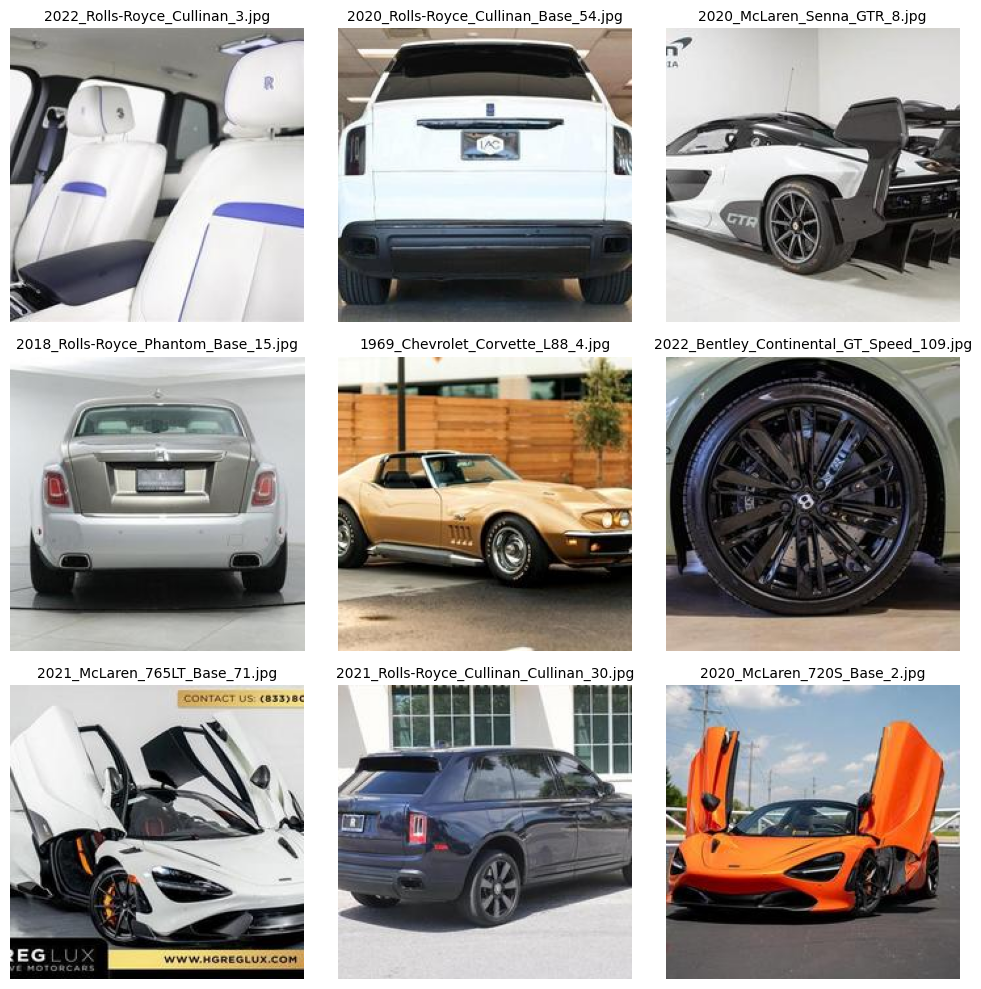

In [81]:
data_dir_object = Path('C:\\Users\\franc\\Documents\\GitHub\\Car_Detection_Chat\\testando')  


# Fetch all images from the dataset
all_images = list(data_dir_object.glob('**/*.jpg'))  # assuming all images are jpg. You can adjust the pattern accordingly.

# Sample 9 random images
random_images = random.sample(all_images, 9)

# Display the images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for ax, img_path in zip(axes.ravel(), random_images):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(img_path.name, fontsize=10)
plt.tight_layout()
plt.show()

In [7]:

# # Verify problems wtht the files

# for root, dirs, files in os.walk(data_dir):
#     for file in files:
#         if file.lower().endswith(('.png', '.jpg', '.jpeg')):
#             file_path = os.path.join(root, file)
#             try:
#                 with Image.open(file_path) as img:
#                     img.verify()
#             except Exception as e:
#                 print(f"Problem with file: {file_path}. Error: {e}")


In [46]:
# # CHECK ENCODING
# def check_utf8_encoding(data_dir):
#     for root, dirs, files in os.walk(data_dir):
#         # # Check directory names
#         # for dir_name in dirs:
#         #     try:
#         #         dir_name.decode('utf-8')
#         #     except UnicodeDecodeError:
#         #         print(f"Non-UTF-8 directory name detected: {os.path.join(root, dir_name)}")
        
#         # Check file names
#         for file_name in files:
#             try:
#                 file_name.encode('utf-8').decode('utf-8')
#             except UnicodeDecodeError:
#                 print(f"Non-UTF-8 file name detected: {os.path.join(root, file_name)}")

# data_dir = 'C:\\Users\\franc\\Documents\\GitHub\\Car_Detection_Chat\\images_backup'
# check_utf8_encoding(data_dir)

In [82]:
def normalize_image(img, label):
    img = img / 255.0
    return img, label

train_ds = train_ds.map(normalize_image)
val_ds = val_ds.map(normalize_image)


In [83]:
sample_img, sample_label = next(iter(train_ds.take(1)))
print("Min Value:", tf.reduce_min(sample_img).numpy())
print("Max Value:", tf.reduce_max(sample_img).numpy())


Min Value: 0.0
Max Value: 1.0


In [84]:
# Enable GPU Memory Growth

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [69]:
# Load the pre-trained ViT model and feature extractor
extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = TFAutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")


All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [85]:
@tf.function

def prepare_data(images, labels):
    images_np = images.numpy()
    # Optional: Clip values just to be sure they're between 0 and 1
    images_np = np.clip(images_np, 0, 1)
    
    inputs = extractor(images_np, return_tensors="tf")
    return inputs["pixel_values"], labels

In [86]:
train_ds = train_ds.map(lambda x, y: tf.py_function(prepare_data, [x, y], [tf.float32, tf.int32]))
val_ds = val_ds.map(lambda x, y: tf.py_function(prepare_data, [x, y], [tf.float32, tf.int32]))

In [87]:
# Fine-tune the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3


131/131 [==============================] - 2814s 21s/step - loss: 3.9362 - accuracy: 0.1102 - val_loss: 3.5521 - val_accuracy: 0.0316
Epoch 2/3
107/131 [=======================>......] - ETA: 8:18 - loss: 3.6806 - accuracy: 0.0330

KeyboardInterrupt: 